In [22]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from numpy.core.numeric import zeros_like

In [23]:
def get_data():
  dataFrame = pd.read_csv("titanic.csv")
  # Elimino estas columnas pues son datos con los que podemos identificar a las personas y no es eso lo que nos interesa. 
  # La información personal no nos interesa pues no podemos generalizar relaciones apartir de esos datos.
  dataFrame.drop(['PassengerId','Name','Ticket','Cabin'], inplace=True, axis=1)
  dataFrame.dropna(inplace = True)
  return pd.get_dummies(dataFrame,columns=["Embarked", 'Sex', 'Pclass'])
  

In [24]:
class myPCA:
  def __init__(self):
    self.inertias = None
    self.principalComponents = None

  def __call__(self, data):
    centeredMatrix = self.centerReduceMatrix(data)
    corMatrix = self.getCorrMatrix(centeredMatrix)
    self.principalComponents, self.inertias = self.getMatrixV(corMatrix)
    C = np.dot(centeredMatrix, self.principalComponents)
    return C

  def centerReduceMatrix(self, data):
    centeredMatrix = zeros_like(data)
    
    for j, column in enumerate(data.T):
      mean = np.mean(column)
      std  = np.std(column)
      for i, value in enumerate(column):
        centeredMatrix[i,j] = (value - mean) / std
    
    return centeredMatrix

  def getCorrMatrix(self, matrix):
    n = matrix.shape[0]
    return np.dot((1/n) * matrix.T, matrix)

  def getMatrixV(self, corMatrix):
    eigenValues, eigenVectors = np.linalg.eig(corMatrix)
    absoluteEigenValues       = np.abs(eigenValues)
    columnsOrder              = np.flip(absoluteEigenValues.argsort())
    absoluteEigenValues       = np.flip(np.sort(absoluteEigenValues))
    
    v = eigenVectors[:,columnsOrder]
    return v, absoluteEigenValues * (1/corMatrix.shape[0])

In [25]:
def plotPrincipalComponents(matrixC, inertias, dframe):
  plt.scatter(np.ravel(matrixC[:,0]),np.ravel(matrixC[:,1]),c = ['b' if i==1 else 'r' for i in dframe["Survived"]])
  plt.xlabel('PCA 1 (%.2f%% inertia)' % (inertias[0]*100,))
  plt.ylabel('PCA 2 (%.2f%% inertia)' % (inertias[1]*100,))
  plt.title('PCA')
  plt.show()

In [26]:
def plotCorrCircle(Vmatrix, dframe, eigenvalues):
  plt.figure(figsize=(15,15))
  plt.axhline(0, color='b')
  plt.axvline(0, color='b')
  for i in range(0, frame.shape[1]):
      plt.arrow(0,0, Vmatrix[i, 0]* np.sqrt(np.abs(eigenvalues[0])),  # x - PC1
                    Vmatrix[i, 1] * np.sqrt(np.abs(eigenvalues[1])),  # y - PC2
                    head_width=0.05, head_length=0.05)
      plt.text(Vmatrix[i, 0] + 0.05, Vmatrix[i, 1] + 0.05, dframe.columns.values[i])
  an = np.linspace(0, 2 * np.pi, 100)
  plt.plot(np.cos(an), np.sin(an),color="b")  # Circle
  plt.axis('equal')
  plt.title('Correlation Circle')
  plt.show()

In [27]:
frame = get_data()
data  = frame.to_numpy()
pca   = myPCA()
C     = pca(data)

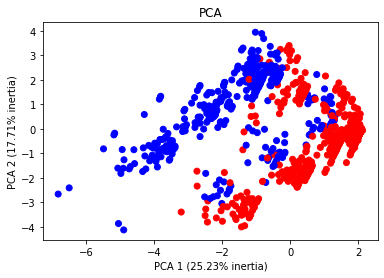

In [28]:
plotPrincipalComponents(C, pca.inertias, frame)

### ¿Cuántos grupos de datos parece haber?
 Hay tres grupos, uno de puntos azules, otros de puntos rojos y en el medio de ambos hay un grupo que mezcla ambos colores.

### ¿Qué comportamientos se pueden observar?
 Podemos interpretar los grupos como que el conjunto azul es mayormente de mujeres el conjunto rojo es mayormente de hombres sin embargo el grupo del medio nos indica que los generos se mezclan en terminos de supervivencia.

### ¿Qué podría explicar estos comportamientos?
 Esto podria ser explicado por los pensemiento social de "Mujeres y niños primeros".

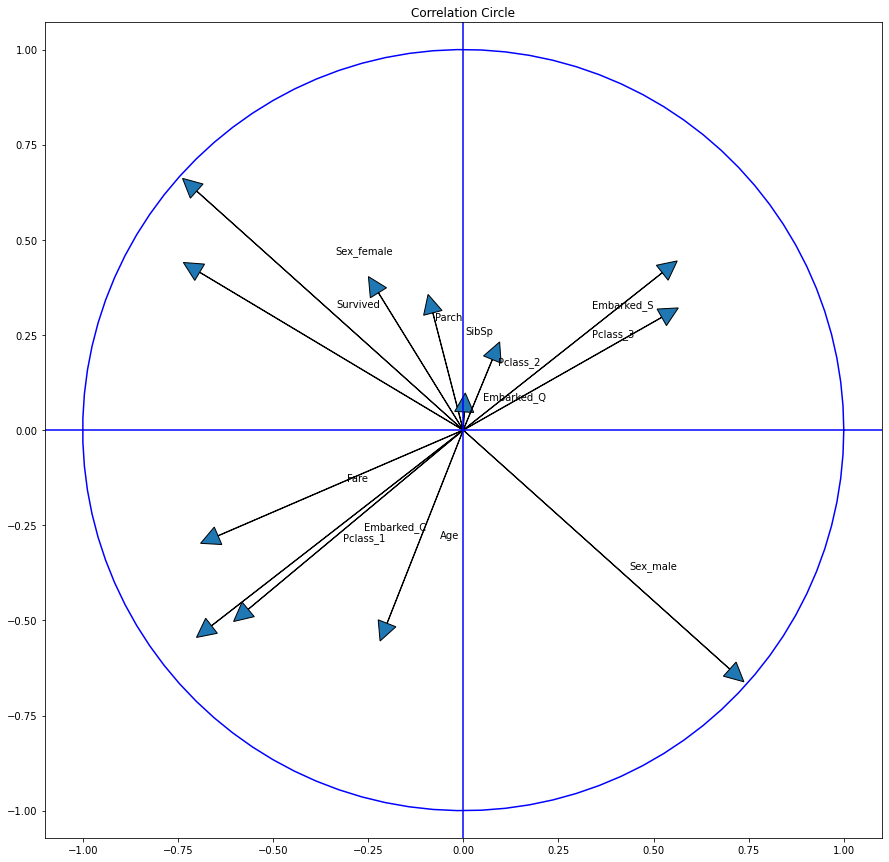

In [29]:
eigenvalues = pca.inertias*pca.principalComponents.shape[0]
plotCorrCircle(pca.principalComponents, frame, eigenvalues)

### ¿Qué nos indica el círculo de correlación?
 - Nos indica que hay una correlación entre la supervivencia, la cantidad familiares abordo (Sibsp y Parch) y si la persona es mujer.
 - Tambien nos indica que el costo (Fare) está relacionado con la edad y ambos están inversamente correlacionados con si la persona embarcó en el puerto S
 - Nos dice que la cateogoria Embarked_Q no es relevante dentro del conjunto de datos.
 - Como edad está correlaciona con el costo entonces podemos decir que las personas que más pagaron eran mayormente de edades más altas

### ¿Qué atributos o características maximizarían mi probabilidad de sobrevivencia?
 - Las probabildades de sobrevivir se maximizan cuando uno es una mujer con una gran cantidad de familiares abordo. Esto debido a las correlaciones que nos mustra el circulo

## Verificación con scikit-learn

In [30]:
df        = get_data()
scaler    = StandardScaler()
df_scaled = scaler.fit_transform(df)
pca2      = PCA()
C2        = pca2.fit_transform(df_scaled)
inertia   = pca2.explained_variance_ratio_
V         = pca2.transform(np.identity(df_scaled.shape[1]))

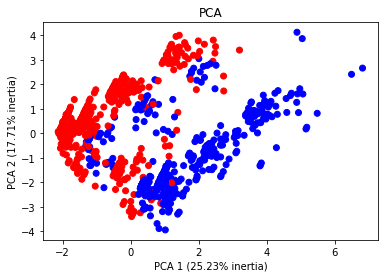

In [31]:
plotPrincipalComponents(C2, inertia, df)

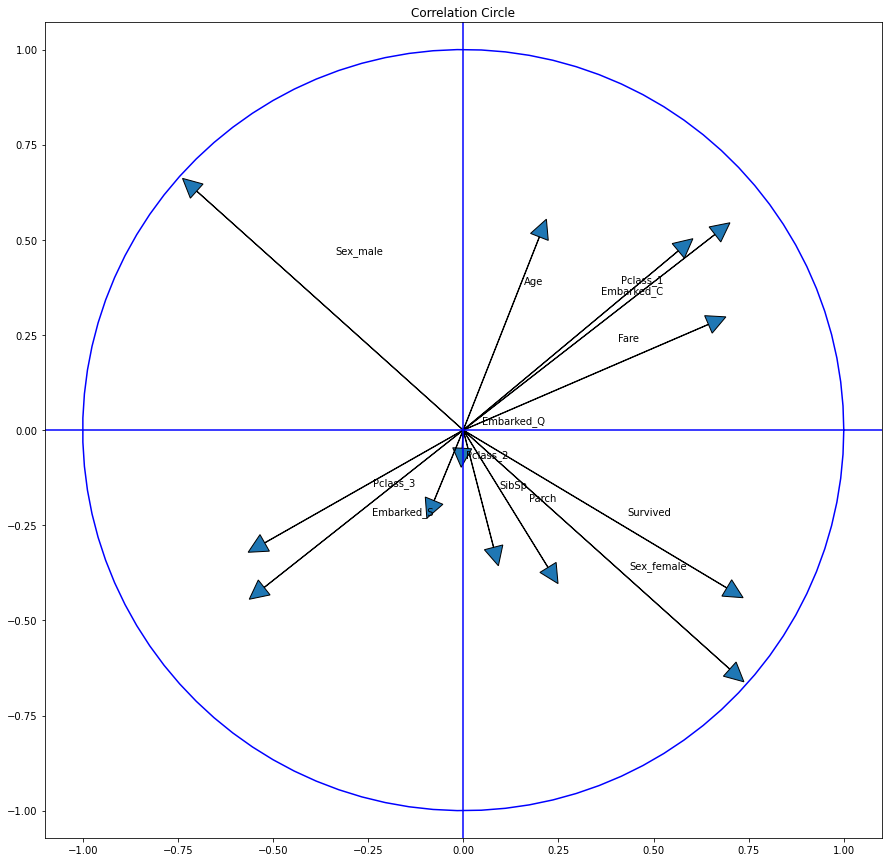

In [32]:
eigenvalues = inertia*V.shape[0]
plotCorrCircle(V, df, eigenvalues)

### ¿Hay alguna diferencia entre las gráficas? De ser así, ¿por qué cree que ocurrió esto? ¿Impacta el resultado de alguna manera?
 Los graficos están rotados pero esto no afecta porque la relación entre las variables es la misma.